In [ ]:
# default_exp modeling.token_classification

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.token_classification

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks like named entity recognition.

In [ ]:
#export
import os, ast, inspect

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from seqeval import metrics as seq_metrics
from transformers import AutoModelForTokenClassification, logging

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock, BlurrDataLoader, get_blurr_tfm, first_blurr_tfm
from blurr.modeling.core import HF_PreCalculatedLoss, Blearner
from blurr.data.token_classification import (
    HF_TokenClassInput, HF_TokenTensorCategory, HF_TokenCategorize, 
    HF_TokenCategoryBlock, HF_TokenClassBeforeBatchTransform
)

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc
from transformers import AutoConfig

from blurr.utils import print_versions
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, hf_splitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 1.7.1
fastai: 2.5.0
transformers: 4.9.2


In [ ]:
#hide_input
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Token classification

The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image. Named entity recognition (NER) is an example of token classification in the NLP space

In [ ]:
# ensures these cols are represented as lists (rather than string)
df_converters = {'tokens': ast.literal_eval, 'labels': ast.literal_eval, 'nested-labels': ast.literal_eval}

# full nlp dataset
# germ_eval_df = pd.read_csv('./data/task-token-classification/germeval2014ner_cleaned.csv', converters=df_converters)

# demo nlp dataset
germ_eval_df = pd.read_csv('./germeval2014_sample.csv', converters=df_converters)

print(len(germ_eval_df))
germ_eval_df.head()

1000


,id,source,tokens,labels,nested-labels,ds_type
0,0,n-tv.de vom 26.02.2005 [2005-02-26],"[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]","[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
1,1,welt.de vom 29.10.2005 [2005-10-29],"[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
2,2,http://www.stern.de/sport/fussball/krawalle-in-der-fussball-bundesliga-dfb-setzt-auf-falsche-konzepte-1553657.html#utm_source=standard&utm_medium=rss-feed&utm_campaign=sport [2010-03-25],"[Ob, sie, dabei, nach, dem, Runden, Tisch, am, 23., April, in, Berlin, durch, ein, pädagogisches, Konzept, unterstützt, wird, ,, ist, allerdings, zu, bezweifeln, .]","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
3,3,stern.de vom 21.03.2006 [2006-03-21],"[Bayern, München, ist, wieder, alleiniger, Top-, Favorit, auf, den, Gewinn, der, deutschen, Fußball-Meisterschaft, .]","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, B-LOCderiv, O, O]","[B-LOC, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]",train
4,4,http://www.fr-online.de/in_und_ausland/sport/aktuell/1618625_Frings-schaut-finster-in-die-Zukunft.html [2008-10-24],"[Dabei, hätte, der, tapfere, Schlussmann, allen, Grund, gehabt, ,, sich, viel, früher, aufzuregen, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train


We are only going to be working with small sample from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) data set ... so the results might not be all that great :).

In [ ]:
labels = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))
print(labels)

['B-LOC', 'B-LOCderiv', 'B-LOCpart', 'B-ORG', 'B-ORGpart', 'B-OTH', 'B-OTHderiv', 'B-OTHpart', 'B-PER', 'B-PERderiv', 'B-PERpart', 'I-LOC', 'I-LOCderiv', 'I-ORG', 'I-ORGpart', 'I-OTH', 'I-PER', 'O']


In [ ]:
model_cls = AutoModelForTokenClassification
pretrained_model_name = "bert-base-multilingual-cased"
config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=model_cls, 
                                                                  config=config)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bert',
 transformers.models.bert.configuration_bert.BertConfig,
 transformers.models.bert.tokenization_bert_fast.BertTokenizerFast,
 transformers.models.bert.modeling_bert.BertForTokenClassification)

In [ ]:
test_eq(hf_config.num_labels, len(labels))

In [ ]:
before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                     is_split_into_words=True, 
                                                     tok_kwargs={ 'return_special_tokens_mask': True })

blocks = (
    HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), 
    HF_TokenCategoryBlock(vocab=labels)
)

def get_y(inp):
    return [ (label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.tokens, inp.labels) ]

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('tokens'),
                   get_y=get_y,
                   splitter=RandomSplitter())

We have to define a `get_y` that creates the same number of labels as there are subtokens for a particular token. For example, my name "Wayde" gets split up into two subtokens, "Way" and "##de". The label for "Wayde" is "B-PER" and we just repeat it for the subtokens.  This all get cleaned up when we show results and get predictions.

In [ ]:
dls = dblock.dataloaders(germ_eval_df, bs=2)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,token / target label
0,"[('Helbig', 'B-OTH'), ('et', 'I-OTH'), ('al.', 'I-OTH'), ('(', 'O'), ('1994', 'O'), (')', 'O'), ('S.', 'O'), ('593.', 'O'), ('Wink', 'O'), ('&', 'B-OTH'), ('Seibold', 'I-OTH'), ('et', 'I-OTH'), ('al.', 'I-OTH'), ('(', 'I-OTH'), ('1998', 'O'), (')', 'O'), ('S.', 'O'), ('32', 'O'), ('Inwieweit', 'O'), ('noch', 'O'), ('andere', 'O'), ('Falken,', 'O'), ('wie', 'O'), ('der', 'O'), ('Afrikanische', 'O'), ('Baumfalke', 'O'), ('(', 'O'), ('Falco', 'B-LOCderiv'), ('cuvieri', 'O'), (')', 'O'), ('oder', 'O'), ('der', 'O'), ('Malaienbaumfalke', 'O'), ('(', 'O'), ('Falco', 'O'), ('serverus', 'O'), (')', 'O'), ('dieser', 'O'), ('Gruppe', 'O'), ('zuzuzählen', 'O'), ('sind,', 'O'), ('ist', 'O'), ('Gegenstand', 'O'), ('der', 'O'), ('Forschung.', 'O')]"
1,"[('Scenes', 'B-OTH'), ('of', 'I-OTH'), ('a', 'I-OTH'), ('Sexual', 'I-OTH'), ('Nature', 'I-OTH'), ('(', 'O'), ('GB', 'O'), ('2006', 'O'), (')', 'O'), ('-', 'O'), ('Regie', 'O'), (':', 'O'), ('Ed', 'B-PER'), ('Blum', 'I-PER'), ('Shortbus', 'B-OTH'), ('(', 'O'), ('USA', 'B-LOC'), ('2006', 'O'), (')', 'O'), ('-', 'O'), ('Regie', 'O'), (':', 'O'), ('John', 'B-PER'), ('Cameron', 'I-PER'), ('Mitchell', 'I-PER'), (':', 'O'), ('Film', 'O'), ('über', 'O'), ('den', 'O'), ('gleichnamigen', 'B-LOCderiv'), ('New', 'I-LOCderiv'), ('Yorker', 'O'), ('Club,', 'O'), ('der', 'O'), ('verschiedensten', 'O'), ('Paaren', 'O'), ('eine', 'O'), ('Plattform', 'O'), ('zur', 'O'), ('Aufarbeitung', 'O'), ('ihrer', 'O'), ('Probleme', 'O'), ('bietet.', 'O')]"


### Metrics

In this section, we'll add helpful metrics for token classification tasks

In [ ]:
#export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if (metric_key == 'accuracy'): return seq_metrics.accuracy_score(targ_toks, pred_toks)
    if (metric_key == 'precision'): return seq_metrics.precision_score(targ_toks, pred_toks)
    if (metric_key == 'recall'): return seq_metrics.recall_score(targ_toks, pred_toks)
    if (metric_key == 'f1'): return seq_metrics.f1_score(targ_toks, pred_toks)
        
    if (metric_key == 'classification_report'): return seq_metrics.classification_report(targ_toks, pred_toks)
        

### Training

In [ ]:
#hide
# next(filter(lambda el: isinstance(el, HF_TokenCategorize), learn.dls.tfms[1]), None)

In [ ]:
#hide
# for x in learn.dls.tfms[1]: print(isinstance(x,HF_TokenCategorize), type(x), HF_TokenCategorize)

In [ ]:
#hide
# asdf = HF_TokenCategorize()

In [ ]:
#hide
# isinstance(asdf,HF_TokenCategorize)

In [ ]:
#hide
# get_blurr_tfm(learn.dls.tfms, tfm_class=HF_TokenCategorize)

In [ ]:
#export
class HF_TokenClassMetricsCallback(Callback):
    """A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.
    
    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """
    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder
        
        store_attr(self=self, names='tok_metrics, kwargs')
        self.custom_metrics_dict = { k:None for k in tok_metrics }
        
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return
        
        # grab the hf_tokenizer from the HF_TokenClassBeforeBatchTransform
        tfm = first_blurr_tfm(self.learn.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform) 
        hf_tok_categorize_tfm = get_blurr_tfm(self.learn.dls.tfms[1], tfm_class=HF_TokenCategorize)
        
        self.hf_tokenizer = tfm.hf_tokenizer
        self.ignore_label_token_id = hf_tok_categorize_tfm.ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = tfm.kwargs
        
        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None
        
        self.do_setup = False
        
    def before_fit(self): self.setup()
    
    
    # --- batch begin/after phases ---
    def after_batch(self):
        if (self.training or self.learn.y is None): return
        
        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0] # yb is TensorText tuple, item 0 is the data
        
        preds_list, targets_list = [], []   
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []
            
            for j in range(targs.shape[1]):
                if (targs[i, j] != self.ignore_label_token_id):
                    item_preds.append(self.dls.vocab[preds[i][j].item()])
                    item_targs.append(self.dls.vocab[targs[i][j].item()])
                    
            preds_list.append(item_preds)
            targets_list.append(item_targs)
            
        self.results += [ (res[0], res[1]) for res in zip(preds_list, targets_list) ]
        
        
    # --- validation begin/after phases ---
    def before_validate(self): self.results = []
        
    def after_validate(self):
        if (len(self.results) < 1): return
        
        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys(): 
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)
        
        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, 
                                                                                   preds, 
                                                                                   'classification_report')
        except ZeroDivisionError as err:
            print(f'Couldn\'t calcualte classification report: {err}')
        
        
    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_TokenClassMetricsCallback()]

learn = Learner(dls, model, opt_func=partial(Adam),cbs=learn_cbs,splitter=hf_splitter)

learn.freeze()

In [ ]:
#hide_output
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 76 x 768        
Embedding                                 91812096   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0].shape

(1, torch.Size([2, 76, 18]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 76]), 2, torch.Size([2, 76]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([152, 18]) torch.Size([152])


In [ ]:
print(len(learn.opt.param_groups))

3


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.002290867641568184, steep=3.630780702224001e-05, valley=0.00019054606673307717, slide=0.00019054606673307717)

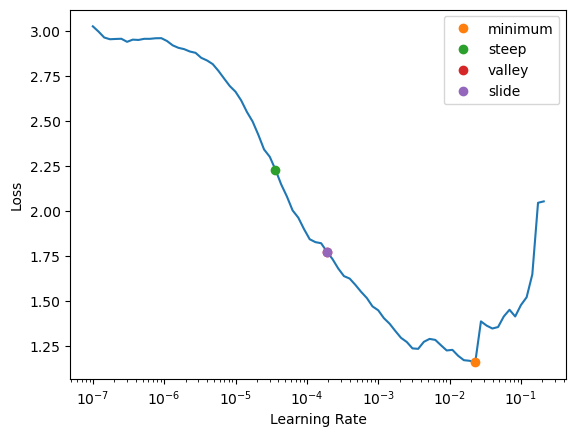

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max= 3e-5, moms=(0.8,0.7,0.8), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.208945,0.132408,0.964616,0.662879,0.660377,0.661626,00:34


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.85      0.75      0.80       105
    LOCderiv       0.68      0.75      0.71        20
     LOCpart       0.00      0.00      0.00         0
         ORG       0.52      0.33      0.40        70
     ORGpart       0.00      0.00      0.00         0
         OTH       0.05      0.50      0.08         2
     OTHpart       0.00      0.00      0.00         0
         PER       0.95      0.84      0.89        68
     PERpart       0.00      0.00      0.00         0

   micro avg       0.66      0.66      0.66       265
   macro avg       0.34      0.35      0.32       265
weighted avg       0.77      0.66      0.71       265



### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(
    x:HF_TokenClassInput, 
    y:HF_TokenTensorCategory, 
    samples, 
    outs, 
    learner, 
    ctxs=None, 
    max_n=6, 
    trunc_at=None, 
    **kwargs
):    
    tfm = first_blurr_tfm(learner.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform) 
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    
    res = L()
    for inp, trg, sample, pred in zip(x, y, samples, outs):
        # recontstruct the string and split on space to get back your pre-tokenized list of tokens
        toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=True)
        pretokenized_toks =  hf_tokenizer.convert_tokens_to_string(toks).split()
        
        # get predictions for subtokens that aren't ignored (e.g. special toks and token parts)
        pred_labels = [ pred_lbl for lbl_id, pred_lbl in zip(trg, ast.literal_eval(pred[0])) if lbl_id != -ignore_token_id ]
        
        trg_labels = ast.literal_eval(sample[1])
        res.append([f'{[ (tok, trg, pred) for idx, (tok, pred, trg) in enumerate(zip(pretokenized_toks, pred_labels, trg_labels)) if (trunc_at is None or idx < trunc_at) ]}'])
        
    display_df(pd.DataFrame(res, columns=['token / target label / predicted label'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=10)

,token / target label / predicted label
0,"[('Außerdem', 'O', 'O'), ('befindet', 'O', 'O'), ('sich', 'O', 'O'), ('im', 'O', 'O'), ('Nordwesten', 'O', 'O'), ('der', 'O', 'O'), ('Stadt', 'O', 'O'), ('(', 'O', 'O'), ('auf', 'O', 'O'), ('dem', 'O', 'O')]"
1,"[('Da', 'O', 'O'), ('ich', 'O', 'O'), ('mir', 'O', 'O'), ('als', 'O', 'O'), ('kleine', 'O', 'O'), ('Rentnerin', 'O', 'O'), ('nicht', 'O', 'O'), ('sehr', 'O', 'O'), ('viel', 'O', 'O'), ('leisten', 'O', 'O')]"


In [ ]:
res = learn.blurr_predict('My name is Wayde and I live in San Diego'.split())
print(res[0][0])

("['O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'O']",)


The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer.

In [ ]:
#export
def _blurr_predict_tokens(
    predict_func, 
    items, 
    tfm
):
    """Remove all the unnecessary predicted tokens after calling `Learner.blurr_predict` or `blurrONNX.predict.
    Aligns the predicted labels, label ids, and probabilities with what you passed in excluding subword tokens
    """
    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs
    
    if (isinstance(items[0], str)): items = [items]
        
    outs = []
    for inp, res in zip(items, predict_func(items)):
        # blurr_predict returns a list for each, we only doing one at a time so git first element of each
        pred_lbls, pred_lbl_ids, probs = res[0][0], res[1][0], res[2][0]
  
        # calculate the number of subtokens per raw/input token so that we can determine what predictions to
        # return
        subtoks_per_raw_tok = [ (entity, len(hf_tokenizer.tokenize(str(entity)))) for entity in inp ]
    
        # very similar to what HF_BatchTransform does with the exception that we are also grabbing
        # the `special_tokens_mask` to help with getting rid or irelevant predicts for any special tokens
        # (e.g., [CLS], [SEP], etc...)
        res = hf_tokenizer(inp, None, 
                           max_length=tfm.max_length,
                           padding=tfm.padding,
                           truncation=tfm.truncation,
                           is_split_into_words=tfm.is_split_into_words,
                           **tok_kwargs)

        special_toks_msk = L(res['special_tokens_mask'])
        actual_tok_idxs = special_toks_msk.argwhere(lambda el: el != 1)
    
        # using the indexes to the actual tokens, get that info from the results returned above
        pred_lbls_list = ast.literal_eval(pred_lbls)
        actual_pred_lbls = L(pred_lbls_list)[actual_tok_idxs]
        actual_pred_lbl_ids = pred_lbl_ids[actual_tok_idxs]
        actual_probs = probs[actual_tok_idxs]
    
        # now, because a raw token can be mapped to multiple subtokens, we need to build a list of indexes composed
        # of the *first* subtoken used to represent each raw token (that is where the prediction is)
        offset = 0
        raw_trg_idxs = []
        for idx, (raw_tok, sub_tok_count) in enumerate(subtoks_per_raw_tok): 
            raw_trg_idxs.append(idx+offset)
            offset += sub_tok_count-1 if (sub_tok_count > 1) else 0
            
        outs.append((inp, 
                     actual_pred_lbls[raw_trg_idxs], 
                     actual_pred_lbl_ids[raw_trg_idxs], 
                     actual_probs[raw_trg_idxs]))

    return outs

In [ ]:
#export
@patch
def blurr_predict_tokens(self:Learner, items, **kargs):
    tfm = first_blurr_tfm(self.dls, before_batch_tfm_class=HF_TokenClassBeforeBatchTransform) 
    return _blurr_predict_tokens(self.blurr_predict, items, tfm)

In [ ]:
show_doc(Learner.blurr_predict_tokens)

<h4 id="Learner.blurr_predict_tokens" class="doc_header"><code>Learner.blurr_predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict_tokens</code>(**`items`**, **\*\*`kargs`**)



**Parameters:**


 - **`items`** : *`<class 'inspect._empty'>`*

 - **`kargs`** : *`<class 'inspect._empty'>`*


In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could go to Germany and watch Bayern Munich play in the Bundesliga."

In [ ]:
res = learn.blurr_predict_tokens(txt.split())
for r in res: print(f'{[(tok, lbl) for tok,lbl in zip(r[0],r[1]) ]}\n')

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-ORG'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]



In [ ]:
res = learn.blurr_predict_tokens([txt.split(), txt2.split()])
for r in res: print(f'{[(tok, lbl) for tok,lbl in zip(r[0],r[1]) ]}\n')

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-ORG'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]

[('I', 'O'), ('wish', 'O'), ('covid', 'O'), ('was', 'O'), ('over', 'O'), ('so', 'O'), ('I', 'O'), ('could', 'O'), ('go', 'O'), ('to', 'O'), ('Germany', 'B-LOC'), ('and', 'O'), ('watch', 'O'), ('Bayern', 'B-ORG'), ('Munich', 'B-ORG'), ('play', 'O'), ('in', 'O'), ('the', 'O'), ('Bundesliga.', 'B-ORG')]



It's interesting (and very cool) how well this model performs on English even thought it was trained against a German corpus.

### Inference

In [ ]:
export_fname = 'tok_class_learn_export'

In [ ]:
learn.export(fname=f'{export_fname}.pkl')
inf_learn = load_learner(fname=f'{export_fname}.pkl')

res = learn.blurr_predict_tokens([txt.split(), txt2.split()])
for r in res: print(f'{[(tok, lbl) for tok,lbl in zip(r[0],r[1]) ]}\n')

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-ORG'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]

[('I', 'O'), ('wish', 'O'), ('covid', 'O'), ('was', 'O'), ('over', 'O'), ('so', 'O'), ('I', 'O'), ('could', 'O'), ('go', 'O'), ('to', 'O'), ('Germany', 'B-LOC'), ('and', 'O'), ('watch', 'O'), ('Bayern', 'B-ORG'), ('Munich', 'B-ORG'), ('play', 'O'), ('in', 'O'), ('the', 'O'), ('Bundesliga.', 'B-ORG')]



## High-level API

### BLearnerForTokenClassification

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#export
@delegates(Blearner.__init__)
class BlearnerForTokenClassification(Blearner):

    def __init__(self, dls, hf_model, **kwargs):
        super().__init__(dls, hf_model, **kwargs)
        
    @classmethod
    def get_model_cls(self): 
        return AutoModelForTokenClassification
    
    @classmethod
    def _get_y(cls, r, tokens, token_labels, tokenizer): 
        return [ (label, len(tokenizer.tokenize(str(entity)))) for entity, label in zip(r[tokens], r[token_labels]) ]
    
    @classmethod
    def get_metrics_cb(self):
        return HF_TokenClassMetricsCallback()
    
    @classmethod
    def _create_learner(
        cls, 
        data, 
        pretrained_model_name_or_path, 
        preprocess_func, 
        tokens_attr, 
        token_labels_attr, 
        labels, 
        dblock_splitter, 
        dl_kwargs, 
        learner_kwargs
    ):
        # get our hf objects
        n_labels = len(labels)
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, 
                                                                          model_cls=cls.get_model_cls(), 
                                                                          config_kwargs={'num_labels': n_labels})
        
        # if we need to preprocess the raw data before creating our DataLoaders
        if (preprocess_func):
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, tokens, token_labels, labels)
            
        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if (hf_tokenizer.pad_token is None): 
            hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})  
            hf_config.pad_token_id = hf_tokenizer.get_vocab()['<pad>']
            hf_model.resize_token_embeddings(len(hf_tokenizer))
        
        # build getters
        if (isinstance(data, pd.DataFrame)):
            get_x = ColReader(tokens_attr)
            get_y = partial(cls._get_y, tokens=tokens_attr, token_labels=token_labels_attr, tokenizer=hf_tokenizer)
        else:
            get_x = ItemGetter(tokens_attr)
            get_y = partial(cls._get_y, tokens=tokens_attr, token_labels=token_labels_attr, tokenizer=hf_tokenizer)
             
        before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                             is_split_into_words=True, 
                                                             tok_kwargs={ 'return_special_tokens_mask': True })
        
        blocks = (
            HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), 
            HF_TokenCategoryBlock(vocab=labels)
        )
        
        dblock = DataBlock(blocks=blocks, 
                           get_x=get_x,
                           get_y=get_y,
                           splitter=dblock_splitter)
        
        dls = dblock.dataloaders(data, **dl_kwargs.copy())
        
        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())
    
    @classmethod
    def from_dataframe(
        cls, 
        df, 
        pretrained_model_name_or_path, 
        preprocess_func=None,
        tokens_attr='tokens', 
        token_labels_attr='token_labels', 
        labels=None, 
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        # we need to tell transformer how many labels/classes to expect
        if (labels is None):
            labels = sorted(list(set([lbls for sublist in df[token_labels_attr].tolist() for lbls in sublist])))
            
        return cls._create_learner(df, pretrained_model_name_or_path, preprocess_func, 
                                   tokens_attr, token_labels_attr, labels, dblock_splitter, 
                                   dl_kwargs, learner_kwargs)
    
        
    @classmethod
    def from_csv(
        cls, 
        csv_file, 
        pretrained_model_name_or_path, 
        preprocess_func=None,
        tokens_attr='tokens', 
        token_labels_attr='labels', 
        labels=None, 
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        df = pd.read_csv(csv_file)
        
        return cls.from_dataframe(df, 
                                  pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                  preprocess_func=preprocess_func,
                                  tokens_attr=tokens_attr, token_labels_attr=token_labels_attr, labels=labels, 
                                  dblock_splitter=dblock_splitter, 
                                  dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    
    @classmethod
    def from_dictionaries(
        cls, 
        ds, 
        pretrained_model_name_or_path, 
        preprocess_func=None,
        tokens_attr='tokens', 
        token_labels_attr='token_labels', 
        labels=None, 
        dblock_splitter=RandomSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        
        # we need to tell transformer how many labels/classes to expect
        if (labels is None):
            all_labels = []
            for item in raw_ds: all_labels += item[token_labels_attr]
            labels = sorted(list(set(all_labels)))

        return cls._create_learner(ds, pretrained_model_name_or_path, preprocess_func, 
                                   tokens_attr, token_labels_attr, labels, dblock_splitter, 
                                   dl_kwargs, learner_kwargs)

In [ ]:
learn = BlearnerForTokenClassification.from_dataframe(germ_eval_df, 'bert-base-multilingual-cased', 
                                                      tokens_attr='tokens', token_labels_attr='labels', 
                                                      dblock_splitter=RandomSplitter(), 
                                                      dl_kwargs={'bs':2})

learn.unfreeze()

In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2)

,token / target label
0,"[('Helbig', 'B-OTH'), ('et', 'I-OTH'), ('al.', 'I-OTH'), ('(', 'O'), ('1994', 'O'), (')', 'O'), ('S.', 'O'), ('593.', 'O'), ('Wink', 'O'), ('&', 'B-OTH'), ('Seibold', 'I-OTH'), ('et', 'I-OTH'), ('al.', 'I-OTH'), ('(', 'I-OTH'), ('1998', 'O'), (')', 'O'), ('S.', 'O'), ('32', 'O'), ('Inwieweit', 'O'), ('noch', 'O'), ('andere', 'O'), ('Falken,', 'O'), ('wie', 'O'), ('der', 'O'), ('Afrikanische', 'O'), ('Baumfalke', 'O'), ('(', 'O'), ('Falco', 'B-LOCderiv'), ('cuvieri', 'O'), (')', 'O'), ('oder', 'O'), ('der', 'O'), ('Malaienbaumfalke', 'O'), ('(', 'O'), ('Falco', 'O'), ('serverus', 'O'), (')', 'O'), ('dieser', 'O'), ('Gruppe', 'O'), ('zuzuzählen', 'O'), ('sind,', 'O'), ('ist', 'O'), ('Gegenstand', 'O'), ('der', 'O'), ('Forschung.', 'O')]"
1,"[('Senden', 'O'), ('Exxon', 'B-ORG'), ('Mobil', 'I-ORG'), ('""', 'O'), ('buy', 'O'), ('""', 'O'), ('Paris', 'B-LOC'), ('(', 'O'), ('aktiencheck.', 'B-ORG'), ('de', 'I-ORG'), ('AG', 'O'), (')', 'O'), ('-', 'O'), (':', 'B-PER'), ('Aymeric', 'I-PER'), ('de', 'O'), ('-', 'O'), ('Villaret,', 'O'), ('Analyst', 'B-ORG'), ('der', 'I-ORG'), ('Société', 'O'), ('Générale,', 'O'), ('stuft', 'O'), ('die', 'O'), ('Aktie', 'O'), ('des', 'B-LOCderiv'), ('US', 'O'), ('-', 'B-ORG'), ('amerikanischen', 'I-ORG'), ('Unternehmens', 'O'), ('Exxon', 'O'), ('Mobil', 'O'), ('(', 'O'), ('ISIN', 'O'), ('US30231G1022', 'O'), ('/', 'O'), ('WKN', 'O'), ('852549', 'O'), (')', 'O'), ('mit', 'O'), ('""', 'O')]"


In [ ]:
#slow
learn.fit_one_cycle(1, lr_max= 3e-5, moms=(0.8,0.7,0.8), cbs=[BlearnerForTokenClassification.get_metrics_cb()])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.186653,0.161262,0.960301,0.642857,0.650190,0.646503,00:35


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=10)

,token / target label / predicted label
0,"[('Scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'I-OTH'), ('Sexual', 'I-OTH', 'I-OTH'), ('Nature', 'I-OTH', 'I-OTH'), ('(', 'O', 'O'), ('GB', 'O', 'I-OTH'), ('2006', 'O', 'O'), (')', 'O', 'B-LOC'), ('-', 'O', 'O')]"
1,"[('Die', 'O', 'O'), ('Flügel', 'O', 'O'), ('Die', 'O', 'O'), ('geöffneten', 'O', 'O'), ('Flügel', 'O', 'O'), ('zeigen', 'O', 'O'), ('in', 'O', 'O'), ('vier', 'O', 'O'), ('Szenen', 'O', 'O'), ('Höhepunkte', 'O', 'O')]"


In [ ]:
#slow
print(learn.token_classification_report)

              precision    recall  f1-score   support

         LOC       0.89      0.69      0.78        86
    LOCderiv       0.43      0.67      0.52        18
     LOCpart       0.00      0.00      0.00         0
         ORG       0.51      0.30      0.38        70
     ORGpart       0.00      0.00      0.00         0
         OTH       0.26      0.64      0.37        14
    OTHderiv       0.00      0.00      0.00         0
     OTHpart       0.00      0.00      0.00         0
         PER       0.92      0.93      0.93        75
    PERderiv       0.00      0.00      0.00         0
     PERpart       0.00      0.00      0.00         0

   micro avg       0.64      0.65      0.65       263
   macro avg       0.27      0.29      0.27       263
weighted avg       0.73      0.65      0.67       263



In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."
txt2 = "I wish covid was over so I could watch Lewandowski score some more goals for Bayern Munich in the Bundesliga."

In [ ]:
res = learn.blurr_predict_tokens(txt.split())
for r in res: print(f'{[(tok, lbl) for tok,lbl in zip(r[0],r[1]) ]}\n')

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'O'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]



In [ ]:
res = learn.blurr_predict_tokens([txt.split(), txt2.split()])
for r in res: print(f'{[(tok, lbl) for tok,lbl in zip(r[0],r[1]) ]}\n')

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'O'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]

[('I', 'O'), ('wish', 'O'), ('covid', 'O'), ('was', 'O'), ('over', 'O'), ('so', 'O'), ('I', 'O'), ('could', 'O'), ('watch', 'O'), ('Lewandowski', 'B-PER'), ('score', 'O'), ('some', 'O'), ('more', 'O'), ('goals', 'O'), ('for', 'O'), ('Bayern', 'B-ORG'), ('Munich', 'B-LOC'), ('in', 'O'), ('the', 'O'), ('Bundesliga.', 'B-ORG')]



## Tests

The tests below to ensure the token classification training code above works for **all** pretrained token classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained token classification models you are working with ... and if any of your pretrained token classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#hide
[ model_type for model_type in BLURR.get_models(task='TokenClassification') 
 if (not model_type.startswith('TF')) ]

['AlbertForTokenClassification',
 'BertForTokenClassification',
 'BigBirdForTokenClassification',
 'CamembertForTokenClassification',
 'CanineForTokenClassification',
 'ConvBertForTokenClassification',
 'DebertaForTokenClassification',
 'DebertaV2ForTokenClassification',
 'DistilBertForTokenClassification',
 'ElectraForTokenClassification',
 'FlaubertForTokenClassification',
 'FunnelForTokenClassification',
 'IBertForTokenClassification',
 'LayoutLMForTokenClassification',
 'LongformerForTokenClassification',
 'MPNetForTokenClassification',
 'MegatronBertForTokenClassification',
 'MobileBertForTokenClassification',
 'RoFormerForTokenClassification',
 'RobertaForTokenClassification',
 'SqueezeBertForTokenClassification',
 'XLMForTokenClassification',
 'XLMRobertaForTokenClassification',
 'XLNetForTokenClassification']

In [ ]:
#hide
pretrained_model_names = [
    'albert-base-v1',
    'bert-base-multilingual-cased',
    'camembert-base',
    'distilbert-base-uncased',
    'google/electra-small-discriminator',
    'flaubert/flaubert_small_cased',
    'huggingface/funnel-small-base',
    'allenai/longformer-base-4096',
    'microsoft/mpnet-base',
    'google/mobilebert-uncased',
    'roberta-base',
    'squeezebert/squeezebert-uncased',
    'xlm-mlm-en-2048',
    'xlm-roberta-base',
    'xlnet-base-cased'
]

In [ ]:
#hide
model_cls = AutoModelForTokenClassification
bsz = 4
seq_sz = 64

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(labels)
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, 
                                                                      model_cls=model_cls, 
                                                                      config=config)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\n')
    
    # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
    if (hf_tokenizer.pad_token is None): 
        hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})  
        hf_config.pad_token_id = hf_tokenizer.get_vocab()['<pad>']
        hf_model.resize_token_embeddings(len(hf_tokenizer)) 
    
    before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                         max_length=seq_sz,
                                                         padding='max_length',
                                                         is_split_into_words=True, 
                                                         tok_kwargs={ 'return_special_tokens_mask': True })

    blocks = (
        HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_TokenClassInput), 
        HF_TokenCategoryBlock(vocab=labels)
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader('tokens'),
                       get_y= lambda inp: [ 
                           (label, len(hf_tokenizer.tokenize(str(entity)))) 
                           for entity, label in zip(inp.tokens, inp.labels) 
                       ],
                       splitter=RandomSplitter())
    
    dls = dblock.dataloaders(germ_eval_df, bs=bsz)

    model = HF_BaseModelWrapper(hf_model)
    learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter).to_fp16()

    learn.create_opt()             # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    b = dls.one_batch()
    
    try:
        print('*** TESTING DataLoaders ***')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max= 3e-5, moms=(0.8,0.7,0.8), 
                            cbs=[HF_TokenClassMetricsCallback(tok_metrics=['accuracy'])])

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, trunc_at=10)
        
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
        
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== albert-base-v1 ===

architecture:	albert
tokenizer:	AlbertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.202546,2.001091,0.762472,00:11


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('die', 'O', 'B-PERpart'), ('flugel', 'O', 'O'), ('die', 'O', 'O'), ('geoffneten', 'O', 'O'), ('flugel', 'O', 'O'), ('zeigen', 'O', 'O'), ('in', 'O', 'O'), ('vier', 'O', 'I-PER'), ('szenen', 'O', 'B-OTH'), ('hohepunkte', 'O', 'O')]"
1,"[('erstmals', 'O', 'B-PERderiv'), ('urkundlich', 'O', 'O'), ('erwahnt', 'O', 'O'), ('ist', 'O', 'O'), ('nimburg', 'B-LOC', 'O'), ('bereits', 'O', 'O'), ('im', 'O', 'I-LOC'), ('jahre', 'O', 'B-ORGpart'), ('977', 'O', 'O'), ('.', 'O', 'O')]"


=== bert-base-multilingual-cased ===

architecture:	bert
tokenizer:	BertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,1.828655,1.631110,0.897870,00:14


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Helbig', 'B-OTH', 'O'), ('et', 'I-OTH', 'O'), ('al.', 'I-OTH', 'O'), ('(', 'O', 'O'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('S.', 'O', 'O'), ('593.', 'O', 'O'), ('Wink', 'O', 'O'), ('&', 'B-OTH', 'O')]"
1,"[('Scenes', 'B-OTH', 'I-LOCderiv'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'O'), ('Sexual', 'I-OTH', 'O'), ('Nature', 'I-OTH', 'O'), ('(', 'O', 'O'), ('GB', 'O', 'O'), ('2006', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O')]"


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.504416,2.437843,0.890098,00:14


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Zugang', 'O', 'O'), ('und', 'O', 'O'), ('Engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('Neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('Netz(', 'O', 'O')]"
1,"[('Senden', 'O', 'O'), ('Exxon', 'B-ORG', 'O'), ('Mobil', 'I-ORG', 'O'), ('""', 'O', 'O'), ('buy', 'O', 'O'), ('""', 'O', 'O'), ('Paris', 'B-LOC', 'O'), ('(', 'O', 'O'), ('aktiencheck.de', 'B-ORG', 'O'), ('AG', 'I-ORG', 'O')]"


=== distilbert-base-uncased ===

architecture:	distilbert
tokenizer:	DistilBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.011009,1.872726,0.881006,00:10


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('zugang', 'O', 'O'), ('und', 'O', 'O'), ('engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('netz', 'O', 'O')]"
1,"[('newsru.', 'B-OTH', 'I-PER'), ('ua', 'O', 'O'), ('/', 'O', 'B-PER'), (':', 'B-OTH', 'O'), ('политисполком', 'I-OTH', 'O'), ('спу', 'I-OTH', 'O'), ('отказал', 'I-OTH', 'O'), ('морозу', 'I-OTH', 'O'), ('в', 'I-OTH', 'O'), ('отставке', 'O', 'O')]"


=== google/electra-small-discriminator ===

architecture:	electra
tokenizer:	ElectraTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.499173,2.408336,0.687841,00:15


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('zugang', 'O', 'O'), ('und', 'O', 'O'), ('engagement', 'O', 'I-ORG'), (':', 'O', 'O'), ('das', 'O', 'I-ORG'), ('eigentlich', 'O', 'O'), ('neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('netz', 'O', 'O')]"
1,"[('(', 'O', 'O'), ('standard', 'B-ORG', 'O'), ('oil', 'I-ORG', 'B-ORG'), ('of', 'I-ORG', 'O'), ('new', 'I-ORG', 'O'), ('jersey', 'I-ORG', 'O'), ('),', 'O', 'B-LOCpart'), ('die', 'O', 'O'), ('ausgesprochen', 'O', 'O'), ('„', 'O', 'O')]"


=== flaubert/flaubert_small_cased ===

architecture:	flaubert
tokenizer:	FlaubertTokenizer

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,1.925693,1.671031,0.605448,00:10


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Zugang', 'O', 'O'), ('und', 'O', 'O'), ('Engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('Neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('Netz', 'O', 'O')]"
1,"[('(', 'O', 'O'), ('Standard', 'B-ORG', 'O'), ('Oil', 'I-ORG', 'I-ORG'), ('of', 'I-ORG', 'B-PER'), ('New', 'I-ORG', 'O'), ('Jersey', 'I-ORG', 'B-PER'), (')', 'O', 'I-ORG'), (',', 'O', 'O'), ('die', 'O', 'I-ORG'), ('ausgesprochen', 'O', 'I-ORG')]"


=== huggingface/funnel-small-base ===

architecture:	funnel
tokenizer:	FunnelTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,1.044137,0.849020,0.887590,00:21


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('helbig', 'B-OTH', 'O'), ('et', 'I-OTH', 'B-OTHderiv'), ('al.', 'I-OTH', 'B-OTHderiv'), ('(', 'O', 'B-OTHderiv'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('s.', 'O', 'B-OTHderiv'), ('593.', 'O', 'B-OTHderiv'), ('wink', 'O', 'B-OTHderiv'), ('&', 'B-OTH', 'B-OTHderiv')]"
1,"[('eine', 'O', 'O'), ('sonderform', 'O', 'O'), ('der', 'O', 'O'), ('reduplizierten', 'O', 'O'), ('komposita', 'O', 'O'), ('sind', 'O', 'O'), ('die', 'O', 'O'), ('sogenannten', 'O', 'O'), ('echoworter,', 'O', 'O'), ('bei', 'O', 'O')]"


=== allenai/longformer-base-4096 ===

architecture:	longformer
tokenizer:	LongformerTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.400259,2.295930,0.775051,01:16


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Mit', 'O', 'B-OTH'), ('der', 'O', 'O'), ('Servicefrau', 'O', 'O'), ('verband', 'O', 'O'), ('Bianca', 'B-PER', 'B-OTH'), ('offenbar', 'O', 'O'), ('eine', 'O', 'B-OTH'), ('Art', 'O', 'O'), ('Freundschaft', 'O', 'O'), ('–', 'O', 'O')]"
1,"[('Senden', 'O', 'B-OTH'), ('Exxon', 'B-ORG', 'O'), ('Mobil', 'I-ORG', 'B-OTH'), ('""', 'O', 'O'), ('buy', 'O', 'O'), ('""', 'O', 'B-OTH'), ('Paris', 'B-LOC', 'O'), ('(', 'O', 'B-OTH'), ('aktiencheck.de', 'B-ORG', 'O'), ('AG', 'I-ORG', 'B-OTH')]"


=== microsoft/mpnet-base ===

architecture:	mpnet
tokenizer:	MPNetTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.325591,2.255767,0.903371,00:14


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('zugang', 'O', 'O'), ('und', 'O', 'O'), ('engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('netz', 'O', 'O')]"
1,"[('scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'O'), ('sexual', 'I-OTH', 'O'), ('nature', 'I-OTH', 'O'), ('(', 'O', 'O'), ('gb', 'O', 'O'), ('2006', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O')]"


=== google/mobilebert-uncased ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,6.142797,4.090872,0.020442,00:19


,token / target label / predicted label
0,"[('scenes', 'B-OTH', 'B-LOC'), ('of', 'I-OTH', 'B-PER'), ('a', 'I-OTH', 'B-PER'), ('sexual', 'I-OTH', 'B-PER'), ('nature', 'I-OTH', 'I-OTH'), ('(', 'O', 'B-LOC'), ('gb', 'O', 'B-OTHpart'), ('2006', 'O', 'O'), (')', 'O', 'I-ORG'), ('-', 'O', 'B-PERderiv')]"
1,"[('die', 'O', 'B-LOC'), ('flugel', 'O', 'B-LOC'), ('die', 'O', 'B-OTHpart'), ('geoffneten', 'O', 'B-LOC'), ('flugel', 'O', 'B-ORGpart'), ('zeigen', 'O', 'B-ORG'), ('in', 'O', 'B-PER'), ('vier', 'O', 'B-ORG'), ('szenen', 'O', 'B-ORG'), ('hohepunkte', 'O', 'B-LOC')]"


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.231987,2.137501,0.903492,00:14


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('(', 'O', 'O'), ('Standard', 'B-ORG', 'O'), ('Oil', 'I-ORG', 'O'), ('of', 'I-ORG', 'O'), ('New', 'I-ORG', 'O'), ('Jersey', 'I-ORG', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('die', 'O', 'O'), ('ausgesprochen', 'O', 'O')]"
1,"[('Senden', 'O', 'O'), ('Exxon', 'B-ORG', 'O'), ('Mobil', 'I-ORG', 'O'), ('""', 'O', 'O'), ('buy', 'O', 'O'), ('""', 'O', 'O'), ('Paris', 'B-LOC', 'O'), ('(', 'O', 'O'), ('aktiencheck.de', 'B-ORG', 'O'), ('AG', 'I-ORG', 'O')]"


=== squeezebert/squeezebert-uncased ===

architecture:	squeezebert
tokenizer:	SqueezeBertTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.496375,2.440524,0.893861,00:16


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('helbig', 'B-OTH', 'O'), ('et', 'I-OTH', 'O'), ('al.', 'I-OTH', 'O'), ('(', 'O', 'O'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('s.', 'O', 'O'), ('593.', 'O', 'O'), ('wink', 'O', 'O'), ('&', 'B-OTH', 'O')]"
1,"[('senden', 'O', 'O'), ('exxon', 'B-ORG', 'O'), ('mobil', 'I-ORG', 'O'), ('""', 'O', 'O'), ('buy', 'O', 'O'), ('""', 'O', 'O'), ('paris', 'B-LOC', 'O'), ('(', 'O', 'O'), ('aktiencheck.', 'B-ORG', 'O'), ('de', 'I-ORG', 'O')]"


=== xlm-mlm-en-2048 ===

architecture:	xlm
tokenizer:	XLMTokenizer

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,0.873767,0.766390,0.858572,00:30


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('nach', 'O', 'O'), ('seiner', 'O', 'O'), ('ruckkehr', 'O', 'O'), ('hielt', 'O', 'O'), ('strummer', 'B-PER', 'O'), ('ein', 'O', 'O'), ('bandmeeting', 'O', 'O'), ('ab', 'O', 'O'), (',', 'O', 'O'), ('in', 'O', 'O')]"
1,"[('newsru.ua', 'B-OTH', 'B-LOCpart'), ('/', 'O', 'B-LOCpart'), (':', 'O', 'B-LOCpart'), ('die', 'B-OTH', 'B-LOCpart'), ('spu', 'I-OTH', 'B-LOCpart'), ('legte', 'I-OTH', 'B-LOCpart'), (',', 'I-OTH', 'B-LOCpart'), ('wie', 'I-OTH', 'B-LOCpart'), ('auch', 'I-OTH', 'B-LOCpart'), ('vier', 'O', 'B-LOCpart')]"


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,2.730136,2.683164,0.005204,00:15


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Zugang', 'O', 'B-OTHderiv'), ('und', 'O', 'I-ORGpart'), ('Engagement', 'O', 'B-OTHderiv'), (':', 'O', 'I-ORGpart'), ('das', 'O', 'I-ORGpart'), ('eigentlich', 'O', 'B-OTHderiv'), ('Neue', 'O', 'B-OTHderiv'), ('an', 'O', 'I-ORGpart'), ('der', 'O', 'B-OTHderiv'), ('Netz(', 'O', 'B-OTHderiv')]"
1,"[('Außerdem', 'O', 'B-OTHderiv'), ('befindet', 'O', 'I-ORGpart'), ('sich', 'O', 'I-ORGpart'), ('im', 'O', 'B-OTHderiv'), ('Nordwesten', 'O', 'B-OTHderiv'), ('der', 'O', 'I-ORGpart'), ('Stadt', 'O', 'B-OTHderiv'), ('(', 'O', 'B-OTHderiv'), ('auf', 'O', 'B-OTHderiv'), ('dem', 'O', 'I-ORGpart')]"


=== xlnet-base-cased ===

architecture:	xlnet
tokenizer:	XLNetTokenizerFast

*** TESTING DataLoaders ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,time
0,1.187605,1.246327,0.583533,00:18


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,token / target label / predicted label
0,"[('Scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'B-OTHpart'), ('a', 'I-OTH', 'B-OTHpart'), ('Sexual', 'I-OTH', 'O'), ('Nature', 'I-OTH', 'O'), ('(', 'O', 'B-OTHpart'), ('GB', 'O', 'O'), ('2006', 'O', 'B-OTHpart'), (')', 'O', 'B-OTHpart'), ('-', 'O', 'B-OTHpart')]"
1,"[('Der', 'O', 'O'), ('notenbeste', 'O', 'O'), ('Zweitligaspieler', 'O', 'O'), ('(', 'O', 'O'), ('2,91', 'O', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('der', 'O', 'O'), ('seine', 'O', 'O'), ('personliche', 'O', 'O')]"


In [ ]:
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,albert,AlbertTokenizerFast,AlbertForTokenClassification,PASSED,
1,bert,BertTokenizerFast,BertForTokenClassification,PASSED,
2,camembert,CamembertTokenizerFast,CamembertForTokenClassification,PASSED,
3,distilbert,DistilBertTokenizerFast,DistilBertForTokenClassification,PASSED,
4,electra,ElectraTokenizerFast,ElectraForTokenClassification,PASSED,
5,flaubert,FlaubertTokenizer,FlaubertForTokenClassification,PASSED,
6,funnel,FunnelTokenizerFast,FunnelForTokenClassification,PASSED,
7,longformer,LongformerTokenizerFast,LongformerForTokenClassification,PASSED,
8,mpnet,MPNetTokenizerFast,MPNetForTokenClassification,PASSED,
9,mobilebert,MobileBertTokenizerFast,MobileBertForTokenClassification,PASSED,


## Summary

This module includes all the low, mid, and high-level API bits for token classification tasks training and inference.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted index.ipynb.
